In [2]:
import OpenEXR
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from math import *
from tqdm.auto import tqdm, trange
from tqdm.contrib import itertools as ti

matplotlib.rcParams['figure.figsize'] = (20, 10)
matplotlib.rcParams['xtick.top'] = False
matplotlib.rcParams['ytick.right'] = False

<Figure size 2000x40000 with 0 Axes>

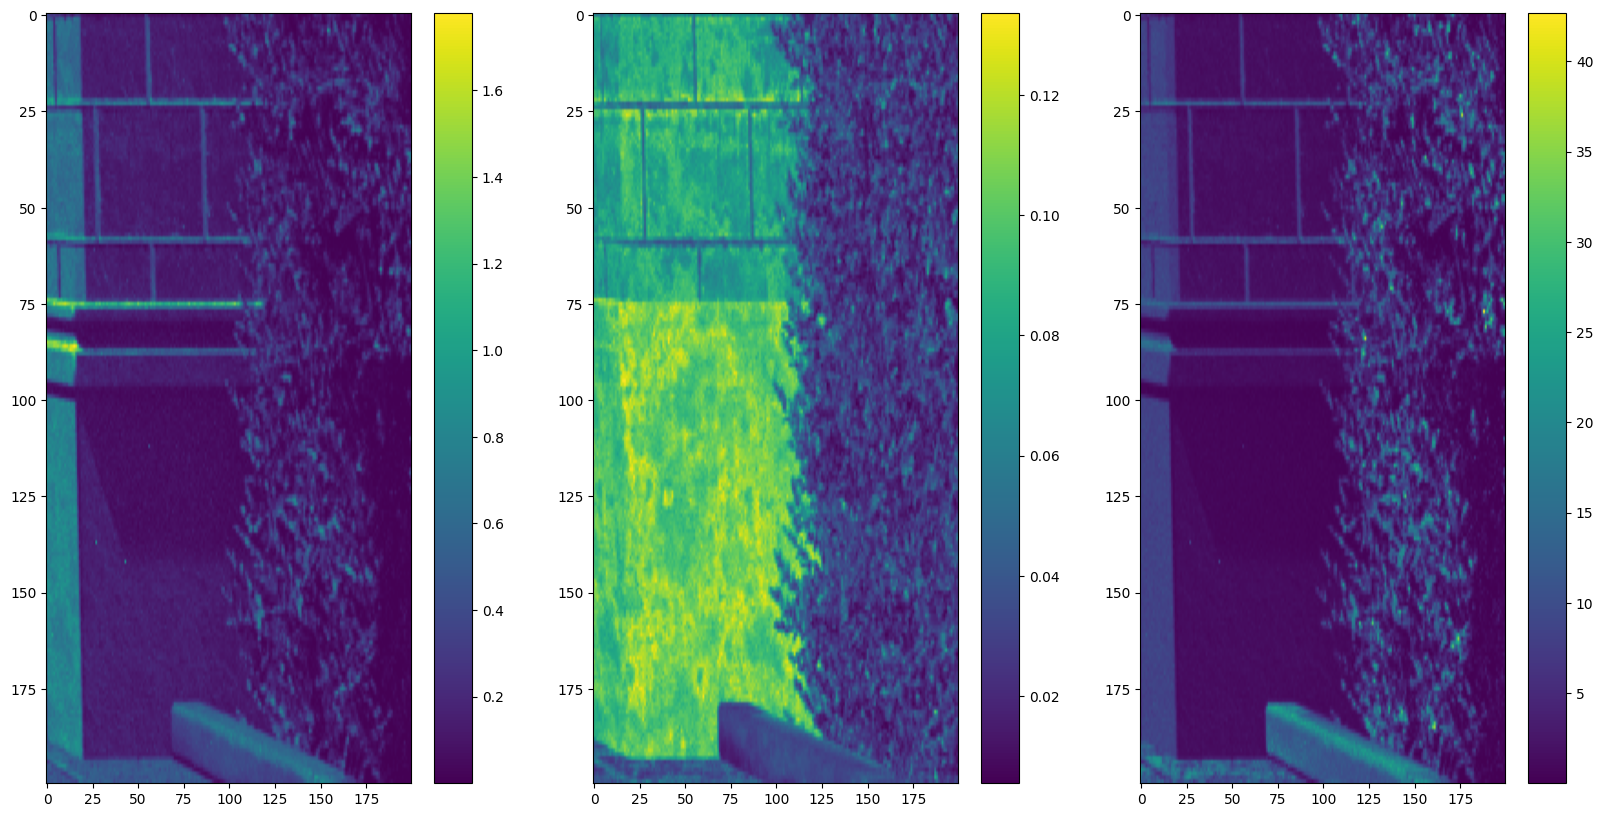

In [3]:
def exr_extract(path, channel):
  exr = OpenEXR.InputFile(path)
  raw_bytes = exr.channel(channel) # S0.580,312nm
  v = np.frombuffer(raw_bytes, dtype=np.float32)
  window = exr.header()['displayWindow']
  height = window.max.y - window.min.y + 1
  width  = window.max.x - window.min.x + 1
  v = np.reshape(v, (height, width))
  v = v[600:800,1500:1700]
  return v

def show(img):
  fig, ax = plt.subplots()
  img = ax.imshow(img)
  ax.set_aspect('auto')
  plt.colorbar(img)
  plt.show()

def showN(imgs, vmin=0, vmax=1):
  fig, axes = plt.subplots(1, len(imgs))
  for ax, img in zip(axes, imgs):
    pos = ax.imshow(img, vmin=vmin, vmax=vmax)
    ax.set_aspect('auto')
    fig.colorbar(pos, ax=ax)
  plt.show()

color = exr_extract('../exr/bistro_cafe.exr', 'G')
albedo = exr_extract('../exr/bistro_cafe_gbuffer.exr', 'Albedo.G')
z = color / albedo

plt.figure().set_figheight(400)
showN([color, albedo, z], vmin=None, vmax=None)

  0%|          | 0/194 [00:00<?, ?it/s]

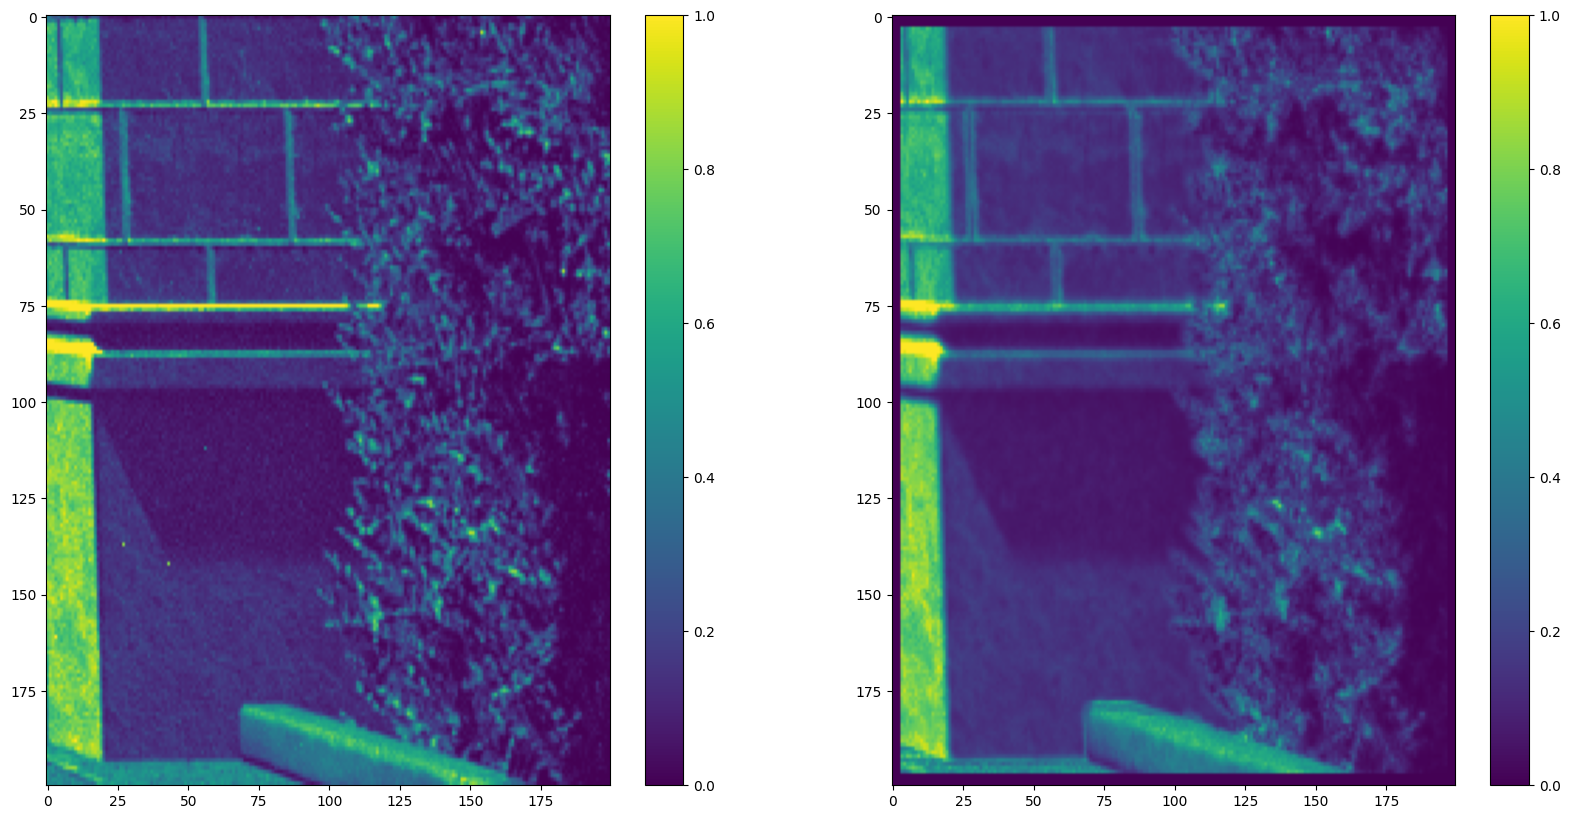

In [4]:
RADIUS = 3
SIDE = 1 + 2 * RADIUS
INV_SQ_RADIUS = 1/(RADIUS**2)

def make_plane(z, mx, my):
  width, height = z.shape
  total_pixels = width * height

  zmean = z.mean()
  W = np.empty_like(z)
  for xx in range(width):
    for yy in range(height):
      wA = exp(-abs(z[xx, yy] - zmean) / zmean)
      wB = exp(-0.5 * 60 * ((xx-mx)**2 + (yy-my)**2) / (width * height))
      W[xx, yy] = wA * wB

  #W /= W.sum()
  value = (z * W / W.sum()).sum()
  return (0, 0, value)

  zflat, Wflat = z.flatten(), W.flatten()
  coords = np.mgrid[0:width, 0:height]
  mA = np.empty((total_pixels, 3))
  mA[:,0] = Wflat * (coords[1].flatten() - mx)
  mA[:,1] = Wflat * (coords[0].flatten() - my)
  mA[:,2] = Wflat

  mAt = mA.transpose()
  mAtA = np.matmul(mAt, mA)
  mAtb = np.matmul(mAt, Wflat * zflat)
  (A, B, C) = np.linalg.solve(mAtA, mAtb)
  return (A, B, C)

filtered = np.zeros_like(color)

for x in trange(RADIUS, color.shape[0]-RADIUS):
  for y in range(RADIUS, color.shape[1]-RADIUS):
#if True:
#    x, y = 150, 125

    try:
      zz = z[x-RADIUS : x+RADIUS+1, y-RADIUS : y+RADIUS+1]

      planeM = make_plane(zz, RADIUS, RADIUS)
      filtered[x,y] = planeM[2]
      #planeTL = make_plane(zz[0:RADIUS,      0:RADIUS],      RADIUS, RADIUS)
      #planeTR = make_plane(zz[RADIUS+1:SIDE, 0:RADIUS],          -1, RADIUS)
      #planeBL = make_plane(zz[0:RADIUS,      RADIUS+1:SIDE], RADIUS, -1)
      #planeBR = make_plane(zz[RADIUS+1:SIDE, RADIUS+1:SIDE],     -1, -1)
      #for dx in range(-RADIUS, RADIUS+1):
      #  for dy in range(-RADIUS, RADIUS+1):
      #    xx, yy = x + dx, y + dy
      #    weight = 1
      #    mid_value = planeM[0] * dx + planeM[1] * dy + planeM[2]
      #    quad = None
      #    if dx > 0:
      #      if dy > 0:   quad = planeBR
      #      else:        quad = planeTR
      #    else:
      #      if dy > 0:   quad = planeBR
      #      else:        quad = planeTL
      #    quad_value = quad[0] * dx + quad[1] * dy + quad[2]
      #    weight = max(z[xx, yy] / quad_value, quad_value / z[xx, yy]) ** 8
      #    Zvalue = ((mid_value + weight * quad_value) / (1 + weight))
      #    filtered[xx, yy] += Zvalue / (SIDE ** 2)
    except:
      filtered[x, y] = z[x, y]

showN([color, filtered * albedo],
#      vmin=None, vmax=None
)